In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import json
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import f1_score

EMD_DIM = 300
def is_char(line):
    for w in line:
        if not ('\u4e00' <= w and w <= '\u9fff'):
            return False
    return True


class Embedding:
    def __init__(self, embed_file='../data/wordem.json'):
        with open(embed_file, 'r') as f:
            self.dic = json.load(f)
        for k in self.dic:
            self.dic[k] = np.array(self.dic[k])

    def embed(self, line):
        emb = np.zeros(EMD_DIM)
        cnt = 0
        for seg in line.split():
            if seg in self.dic:
                emb += self.dic[seg]
                cnt += 1
        emb /= cnt
        return emb

    def emb_dic(self):
        return self.dic


class MyDataset(Dataset):
    """params: name, embed_file_path, name in ['train', 'test']"""
    def __init__(self, name, embed_path='../data/wordem.json', mode='int'):
        super(Dataset, self).__init__()
        self.embed = Embedding(embed_path)
        # with open('../data/' + name + '.text', 'r') as f:
            # text = json.load(f)
        # with open('../data/' + name + '.label', 'r') as f:
            # label = json.load(f)
        with open('../data/{}_text_label.json'.format(name), 'r') as f:
            text_label = json.load(f)
        text, label = text_label[0], text_label[1]
        self.feat = torch.Tensor([self.embed.embed(l) for l in text])
        if mode == 'int':
            self.label = [np.array(l[1:]) for l in label]
        elif mode == 'prob' or mode == 'float':
            self.label = list()
            for l in label:
                tot_vote = l[0]
                prob = np.array([vote / tot_vote for vote in l[1:]])
                self.label.append(prob)
            self.label = torch.Tensor(self.label)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, item):
        return self.feat[item], self.label[item]

In [2]:
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
            我们在构建模型的时候，能够使用nn.Sequential的地方，尽量使用它，因为这样可以让结构更加清晰
        """
        super(TwoLayerNet, self).__init__()
        self.twolayernet = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        # x = np.mat(x)
        # x = x.view(-1, 300)
        """
        在forward函数中，我们会接受一个Variable，然后我们也会返回一个Varible
        """
        x = x.view(-1, 300)
        y_pred = self.twolayernet(x)
        return y_pred


In [3]:
# train part
BATCH_SIZE = 64
lr = 0.001
EPOCHS = 20
EMBED_FILE_PATH = '../data/wordem.json'

trainset = MyDataset(name='train', embed_path=EMBED_FILE_PATH, mode='float')
testset = MyDataset(name='test', embed_path=EMBED_FILE_PATH, mode='float')

print(len(trainset))
print(len(testset))

2342
2228


In [4]:
trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
def score_cor_ma_mi_wei(net2):
    net2.eval()
    cnt = 0
    # for feat, label in testset:
    pred_emotions = list()
    true_emotions = list()
    for feat, label in testset:
        if torch.argmax(net2(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
            cnt += 1
        pred_emotions.append(int(torch.argmax(net2(torch.Tensor(feat))).item()))
        true_emotions.append(int(torch.argmax(torch.Tensor(label)).item()))
    # print('correct:', cnt)
    # print('ratio:', cnt / test_size)

    # 返回值的第一项是皮尔森相关系数，第二项是p_value值。一般来说皮尔森相关系数越大，p_value越小，线性相关性就越大。但是看到note里讲的。p_value不是完全的可靠，当数据量大于500的时候，可能是合理的。
    pears = list()
    for feat, label in testset:
        pred = torch.Tensor(net2(feat)[0]).detach().numpy()
        pears.append(pearsonr(label, pred))

    # print('corr:', np.mean(corr))
    # print('f_score_macro:', f1_score(true_emotions, pred_emotions, average='macro'))
    # print('f_score_micro:', f1_score(true_emotions, pred_emotions, average='micro'))
    # print('f_score_weighted:', f1_score(true_emotions, pred_emotions, average='weighted'))
    return [np.mean(pears), f1_score(true_emotions, pred_emotions, average='macro'), 
           f1_score(true_emotions, pred_emotions, average='micro'), f1_score(true_emotions, pred_emotions, average='weighted')]
    # corr -> 0.6611378491929296
    # ma -> 0.3289856648150263
    # mi -> 0.5501562344438627

In [45]:
# bert slower
train_loss_list = list()
train_ratio_list = list()
test_loss_list = list()
test_ratio_list = list()
corr_list = list()
macro_list = list()
micro_list = list()
weighted_list = list()

trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False)

train_size = 2342
test_size = 2228
input_size, hidden_size, output_size = 300, 100, 8
model = TwoLayerNet(input_size, hidden_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
NAME = 'AdamNormalize'
loss_fn = nn.MSELoss()

EPOCH = 100
for epoch in range(EPOCH):
    model.train()
    train_loss = 0.0
    traincnt = 0
    for feat, label in trainloader:
        torch.nn.functional.normalize(feat, dim=1)
        optimizer.zero_grad()
        pred = model(feat)
        loss = loss_fn(pred, label)
        # print(pred.shape, label.shape)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch %d,\t train_loss %f' % (epoch, train_loss / train_size), end='\t')
    train_loss_list.append(train_loss / train_size)
    
    
    model.eval()
    train_correc = 0
    for feat, label in trainset:
        torch.nn.functional.normalize(feat, dim=0)
        if torch.argmax(model(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
            train_correc += 1
    print('train_ratio %f' % (train_correc / train_size), end='\t')
    train_ratio_list.append(train_correc / train_size)
    
    evalcnt = 0
    eval_loss = 0.0
    for feat, label in testset:
        torch.nn.functional.normalize(feat, dim=0)
        if torch.argmax(model(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
            evalcnt += 1
        pred = model(feat)
        loss = loss_fn(pred[0], label)
        # print(pred[0].shape, label.shape)
        eval_loss += loss.item()
    print('eval_loss: %f' % (eval_loss / test_size), end='\t')
    print('eval_ratio:', evalcnt / test_size)
    test_loss_list.append(eval_loss / test_size)
    test_ratio_list.append(evalcnt / test_size)
    four_score = score_cor_ma_mi_wei(model)
    corr_list.append(four_score[0])
    macro_list.append(four_score[1])
    micro_list.append(four_score[2])
    weighted_list.append(four_score[3])

Epoch 0,	 train_loss 0.000702	train_ratio 0.450043	eval_loss: 0.035885	eval_ratio: 0.5040394973070018
Epoch 1,	 train_loss 0.000555	train_ratio 0.495730	eval_loss: 0.033320	eval_ratio: 0.5394973070017953
Epoch 2,	 train_loss 0.000525	train_ratio 0.515371	eval_loss: 0.031600	eval_ratio: 0.5547576301615799
Epoch 3,	 train_loss 0.000503	train_ratio 0.520068	eval_loss: 0.031097	eval_ratio: 0.5596947935368043
Epoch 4,	 train_loss 0.000489	train_ratio 0.538856	eval_loss: 0.030238	eval_ratio: 0.5709156193895871
Epoch 5,	 train_loss 0.000479	train_ratio 0.538856	eval_loss: 0.029853	eval_ratio: 0.5691202872531418
Epoch 6,	 train_loss 0.000470	train_ratio 0.552519	eval_loss: 0.029511	eval_ratio: 0.5740574506283662
Epoch 7,	 train_loss 0.000466	train_ratio 0.556362	eval_loss: 0.029157	eval_ratio: 0.5785457809694794
Epoch 8,	 train_loss 0.000459	train_ratio 0.559351	eval_loss: 0.029305	eval_ratio: 0.5816876122082585
Epoch 9,	 train_loss 0.000451	train_ratio 0.566183	eval_loss: 0.028748	eval_ratio:

Epoch 80,	 train_loss 0.000315	train_ratio 0.669513	eval_loss: 0.028291	eval_ratio: 0.6000897666068222
Epoch 81,	 train_loss 0.000319	train_ratio 0.686593	eval_loss: 0.028090	eval_ratio: 0.6068222621184919
Epoch 82,	 train_loss 0.000312	train_ratio 0.682750	eval_loss: 0.028184	eval_ratio: 0.6063734290843806
Epoch 83,	 train_loss 0.000309	train_ratio 0.686166	eval_loss: 0.028315	eval_ratio: 0.6077199281867145
Epoch 84,	 train_loss 0.000309	train_ratio 0.681042	eval_loss: 0.028616	eval_ratio: 0.6063734290843806
Epoch 85,	 train_loss 0.000310	train_ratio 0.684885	eval_loss: 0.028423	eval_ratio: 0.6023339317773788
Epoch 86,	 train_loss 0.000309	train_ratio 0.698121	eval_loss: 0.028962	eval_ratio: 0.6032315978456014
Epoch 87,	 train_loss 0.000310	train_ratio 0.695132	eval_loss: 0.028739	eval_ratio: 0.6032315978456014
Epoch 88,	 train_loss 0.000305	train_ratio 0.703672	eval_loss: 0.028890	eval_ratio: 0.5978456014362658
Epoch 89,	 train_loss 0.000304	train_ratio 0.697694	eval_loss: 0.028515	e

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
def paint(name, color='red', leng=0):
    vals = eval(name + '_list')
    if leng == 0:
        leng = len(vals)
    vals = vals[:leng]
    x_axis = list(range(len(vals)))
    plt.figure(figsize=(12.8, 9.6))
    plt.xlim(0, np.max(x_axis) * 1.1)
    plt.ylim(0, np.max(vals) * 1.1)
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.text(x=np.max(x_axis) * 0.3, y=np.max(vals) * 0.9, s=name + '_curve', fontsize=20)
    plt.plot(x_axis, vals, label=name, color=color)
    plt.legend()
    plt.savefig('./png/compare_{}_{}.png'.format(NAME, name))

In [47]:
# for i, j in trainloader:
#     print(i.shape)
#     break

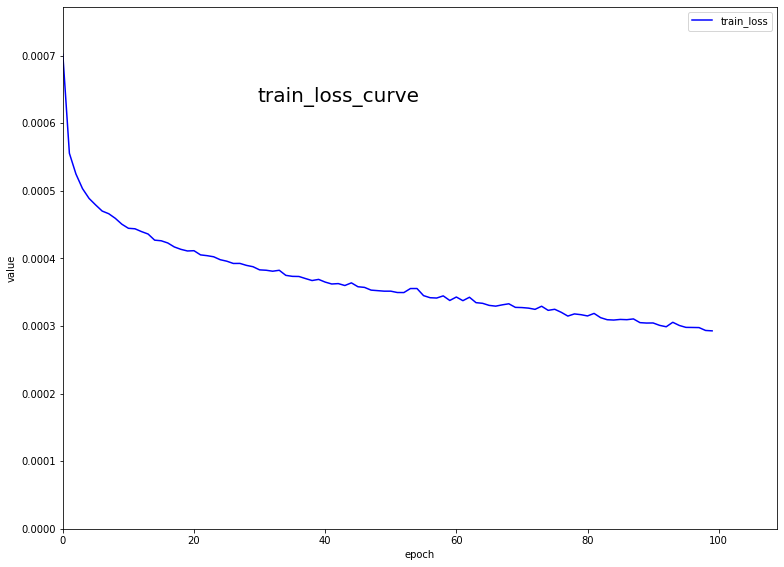

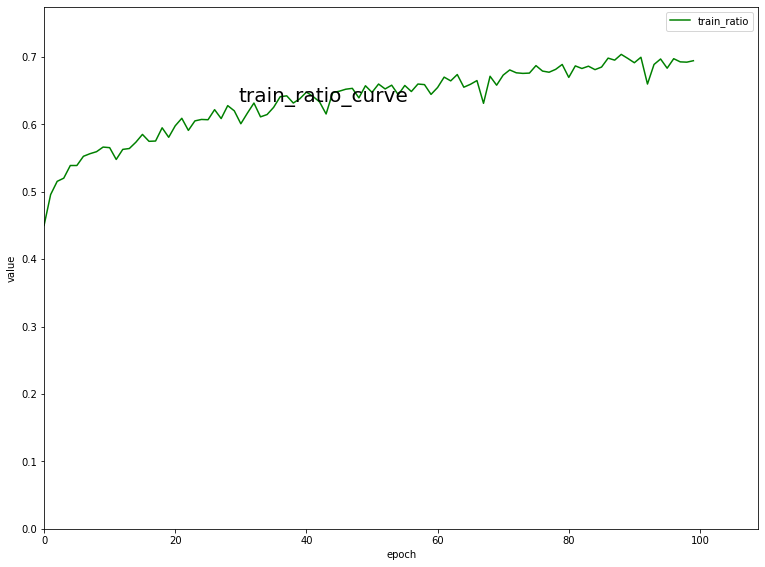

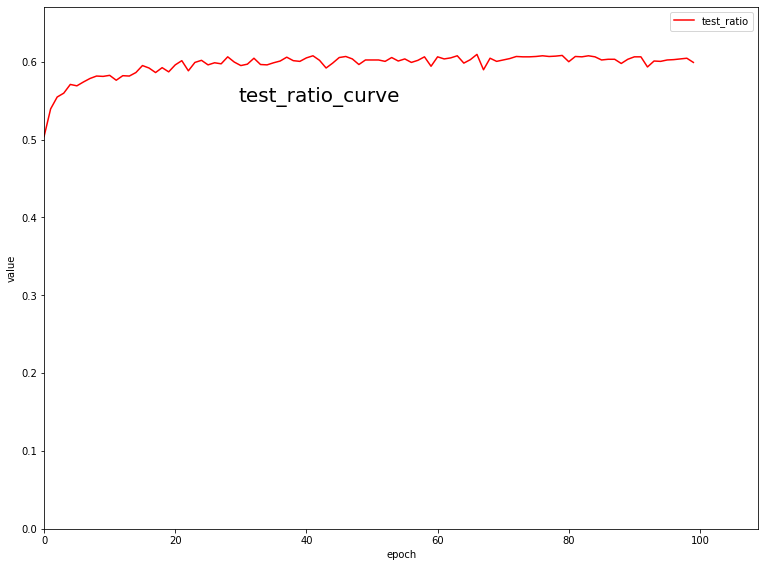

In [48]:
paint('train_loss', 'b')
paint('train_ratio', 'g')
# paint('test_loss', 'c')
paint('test_ratio', 'r')

In [11]:
# bert slower
train_loss_list = list()
train_ratio_list = list()
test_loss_list = list()
test_ratio_list = list()
corr_list = list()
macro_list = list()
micro_list = list()
weighted_list = list()

model = TwoLayerNet(input_size, hidden_size, output_size)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

loss_fn = nn.MSELoss()

EPOCH = 50
for epoch in range(EPOCH):
    model.train()
    train_loss = 0.0
    traincnt = 0
    for feat, label in trainloader:
        optimizer.zero_grad()
        pred = model(feat)
        loss = loss_fn(pred, label)
        # print(pred.shape, label.shape)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch %d,\t train_loss %f' % (epoch, train_loss / train_size), end='\t')
    train_loss_list.append(train_loss / train_size)
    
    
    model.eval()
    train_correc = 0
    for feat, label in trainset:
        if torch.argmax(model(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
            train_correc += 1
    print('train_ratio %f' % (train_correc / train_size), end='\t')
    train_ratio_list.append(train_correc / train_size)
    
    evalcnt = 0
    eval_loss = 0.0
    for feat, label in testset:
        if torch.argmax(model(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
            evalcnt += 1
        pred = model(feat)
        loss = loss_fn(pred[0], label)
        # print(pred[0].shape, label.shape)
        eval_loss += loss.item()
    print('eval_loss: %f' % (eval_loss / test_size), end='\t')
    print('eval_ratio:', evalcnt / test_size)
    test_loss_list.append(eval_loss / test_size)
    test_ratio_list.append(evalcnt / test_size)
    four_score = score_cor_ma_mi_wei(model)
    corr_list.append(four_score[0])
    macro_list.append(four_score[1])
    micro_list.append(four_score[2])
    weighted_list.append(four_score[3])


# torch.save(model.state_dict(), './png/compare_{}.dict'.format(NAME))

Epoch 0,	 train_loss 0.001205	train_ratio 0.050384	eval_loss: 0.072697	eval_ratio: 0.04039497307001795
Epoch 1,	 train_loss 0.001054	train_ratio 0.061486	eval_loss: 0.063430	eval_ratio: 0.05565529622980251
Epoch 2,	 train_loss 0.000934	train_ratio 0.392400	eval_loss: 0.056648	eval_ratio: 0.4483842010771993
Epoch 3,	 train_loss 0.000848	train_ratio 0.401366	eval_loss: 0.051714	eval_ratio: 0.46409335727109513
Epoch 4,	 train_loss 0.000787	train_ratio 0.401366	eval_loss: 0.048173	eval_ratio: 0.46409335727109513
Epoch 5,	 train_loss 0.000742	train_ratio 0.401366	eval_loss: 0.045682	eval_ratio: 0.46409335727109513
Epoch 6,	 train_loss 0.000712	train_ratio 0.401366	eval_loss: 0.043907	eval_ratio: 0.46409335727109513
Epoch 7,	 train_loss 0.000691	train_ratio 0.401366	eval_loss: 0.042680	eval_ratio: 0.46409335727109513
Epoch 8,	 train_loss 0.000677	train_ratio 0.401366	eval_loss: 0.041779	eval_ratio: 0.46409335727109513
Epoch 9,	 train_loss 0.000667	train_ratio 0.401366	eval_loss: 0.041179	eva

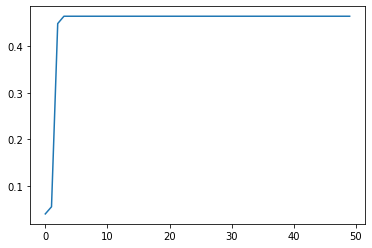

In [14]:
plt.figure()
plt.plot(list(range(50)), test_ratio_list)

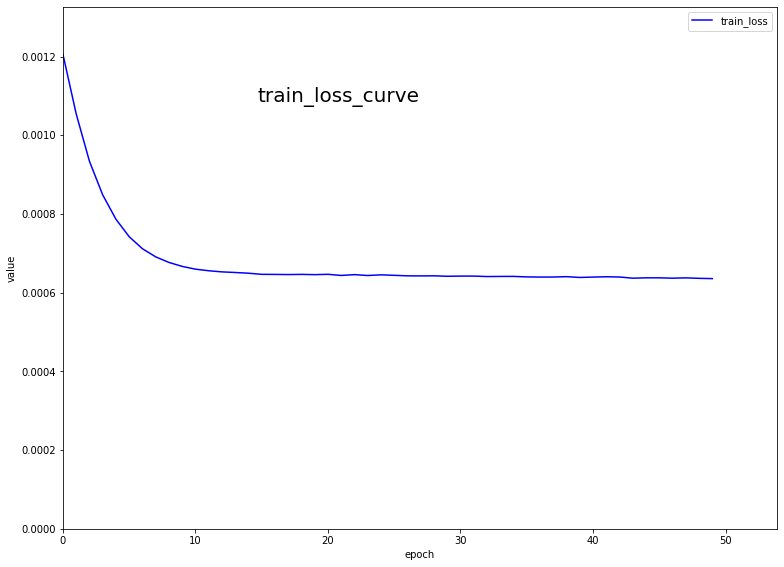

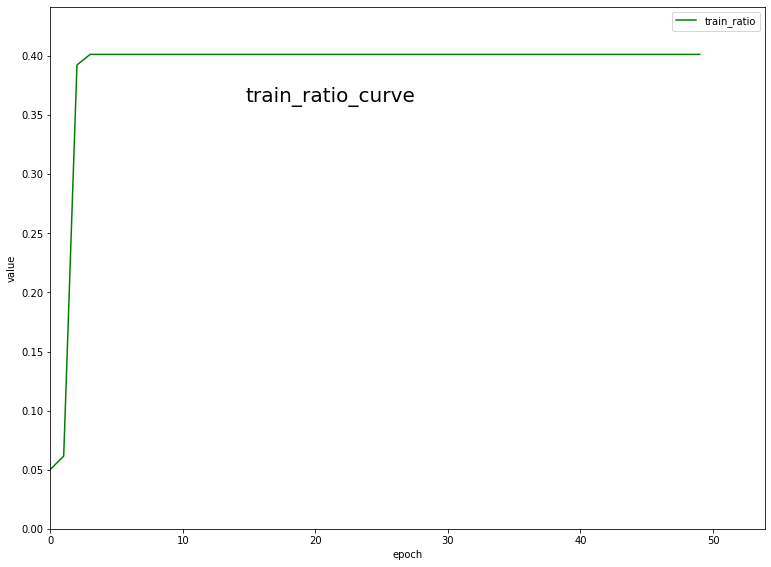

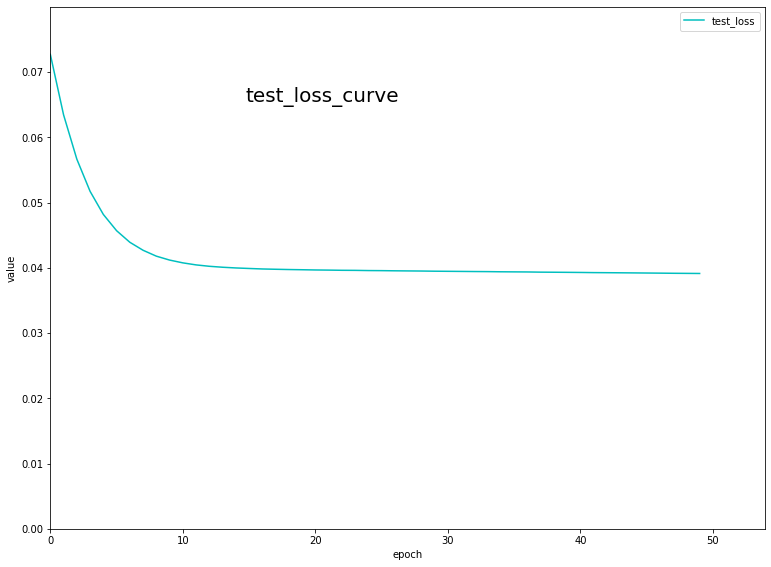

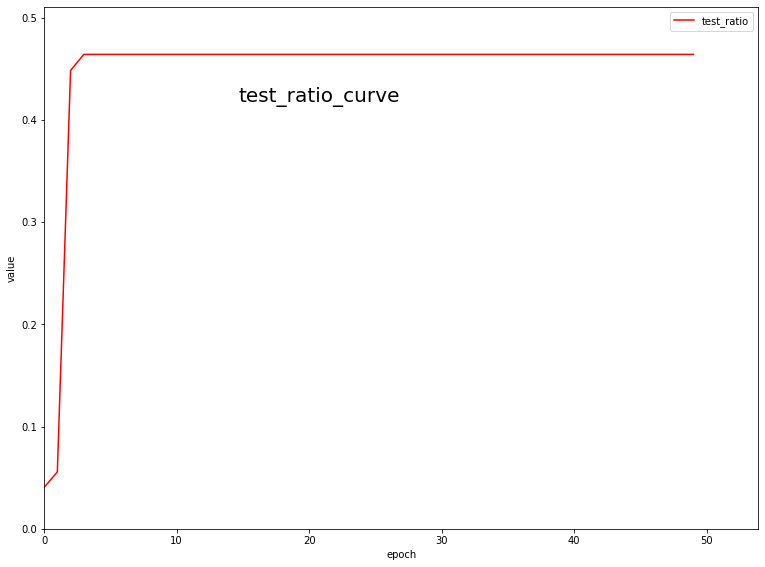

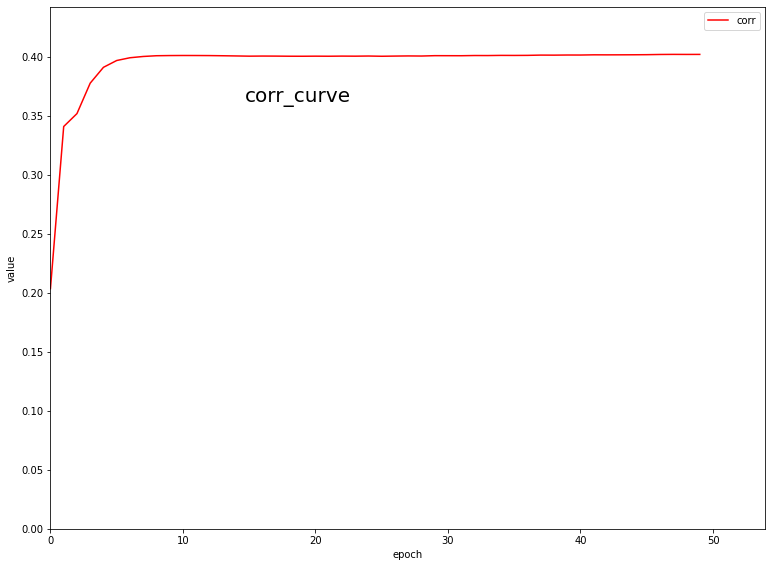

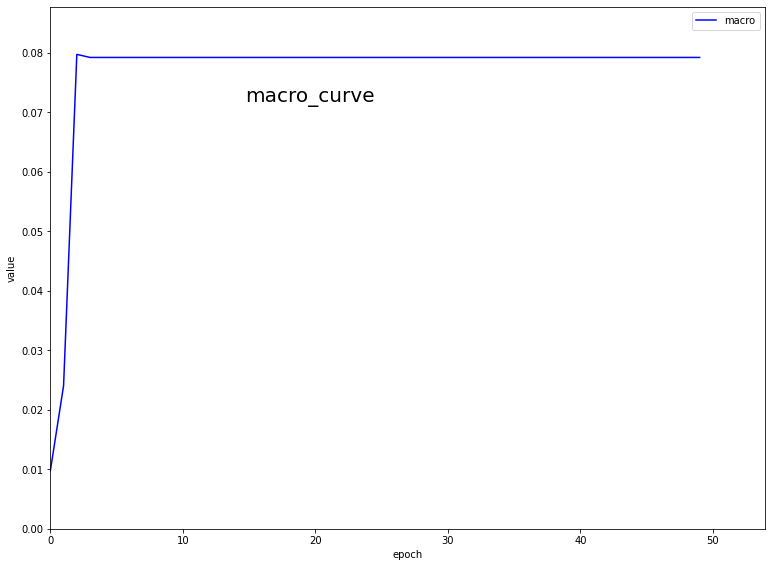

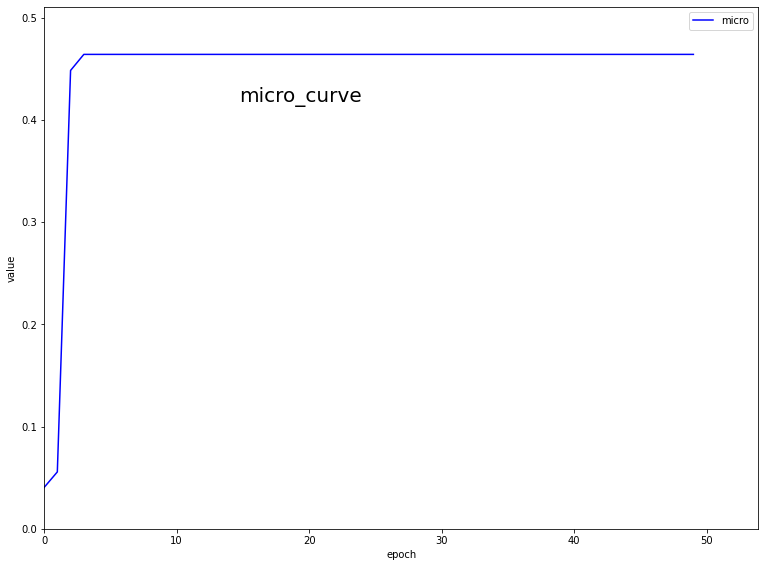

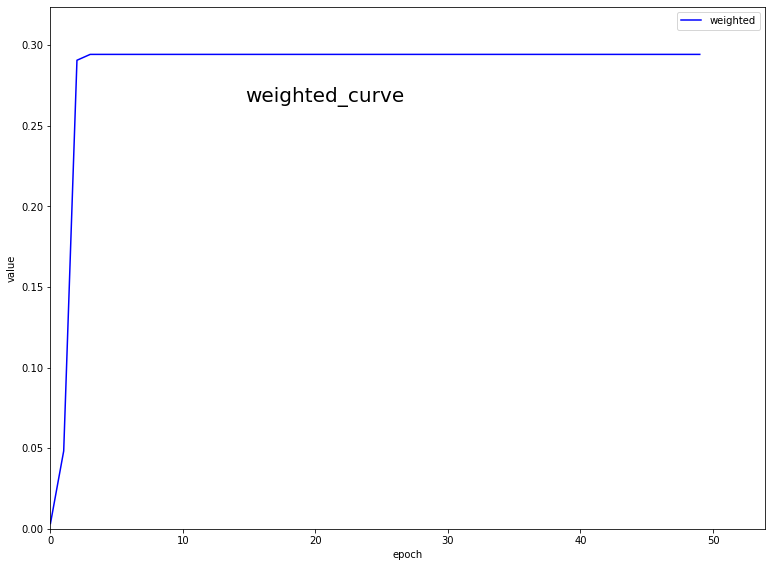

In [13]:
NAME = 'SGD_MOMEN0.9'
paint('train_loss', 'b')
paint('train_ratio', 'g')
paint('test_loss', 'c')
paint('test_ratio', 'r')
paint('corr', 'r')
paint('macro', 'b')
paint('micro', 'b')
paint('weighted', 'b')

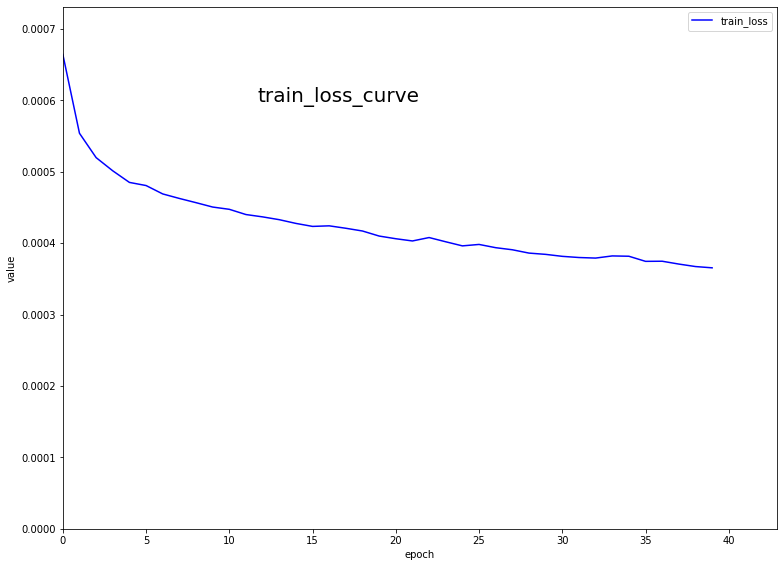

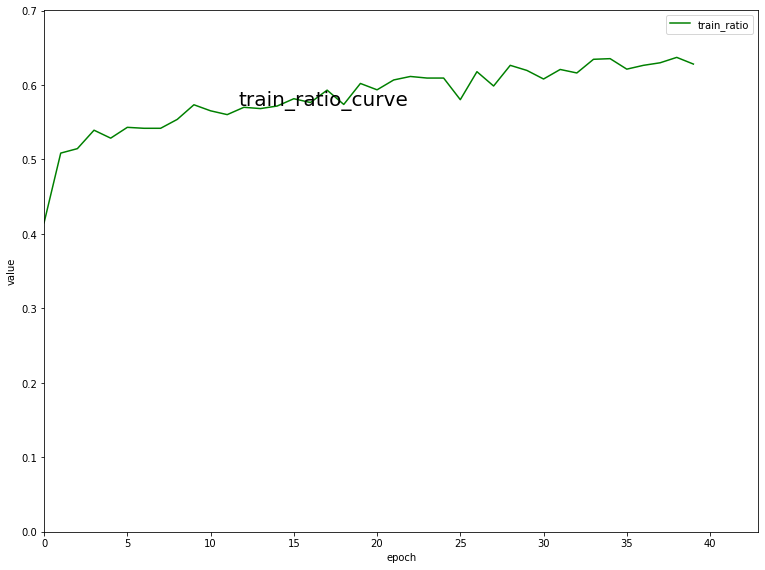

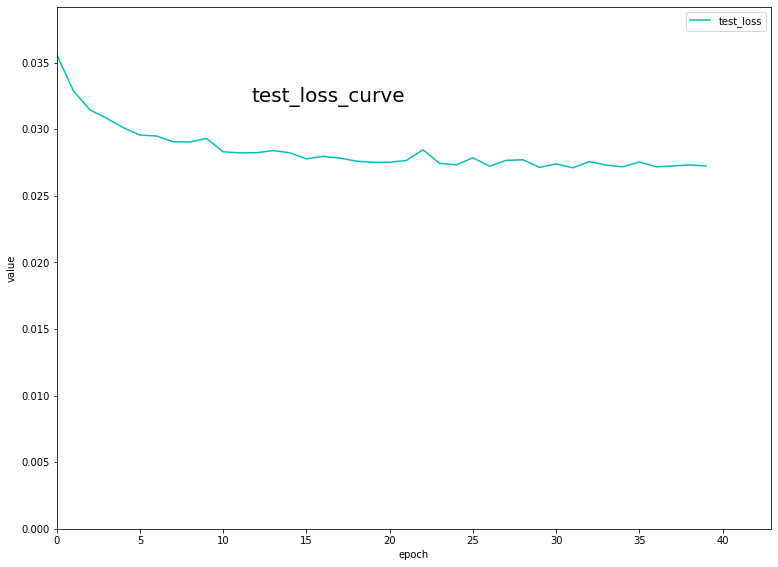

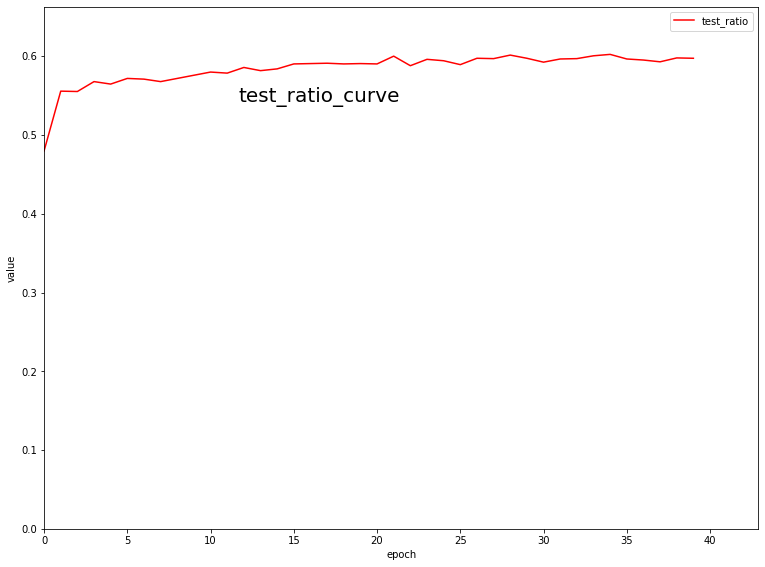

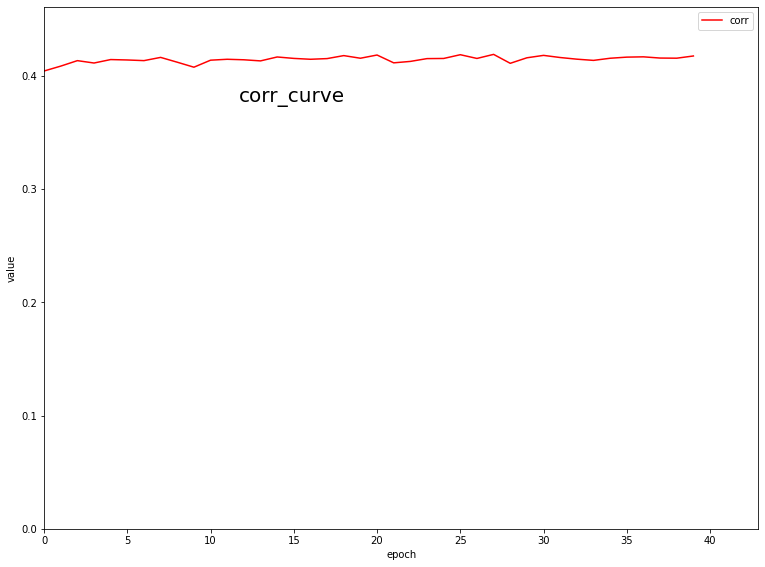

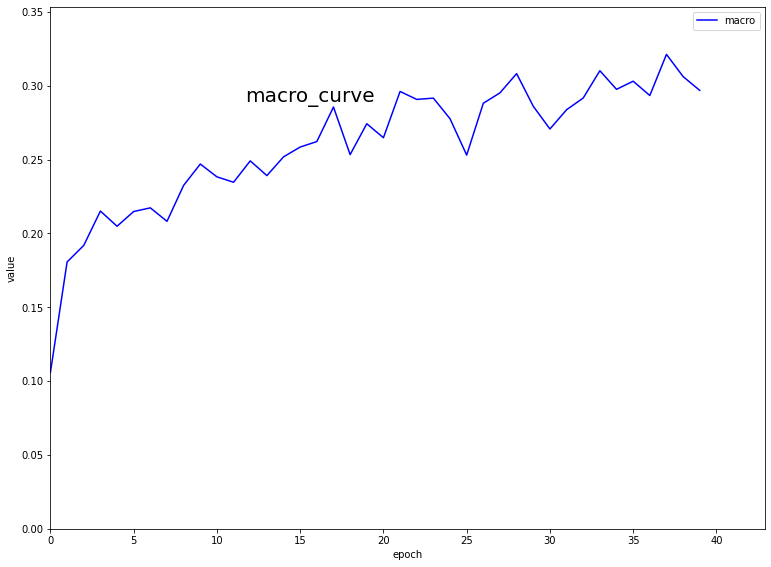

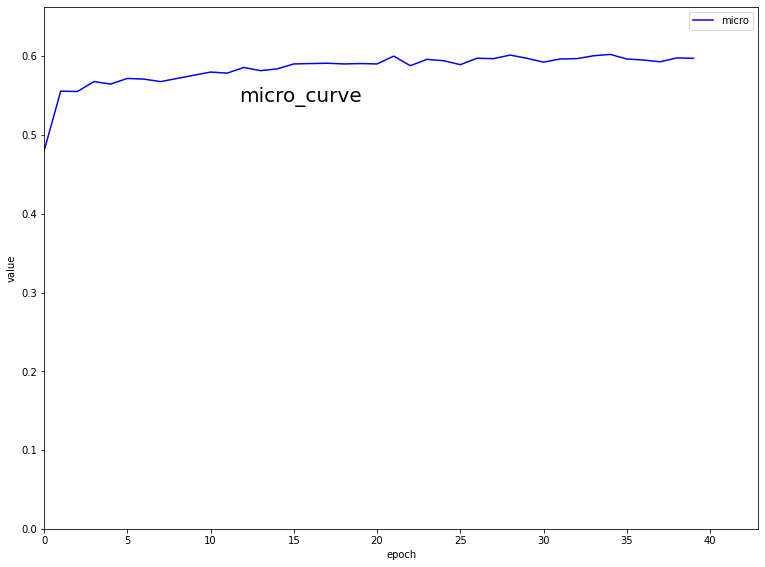

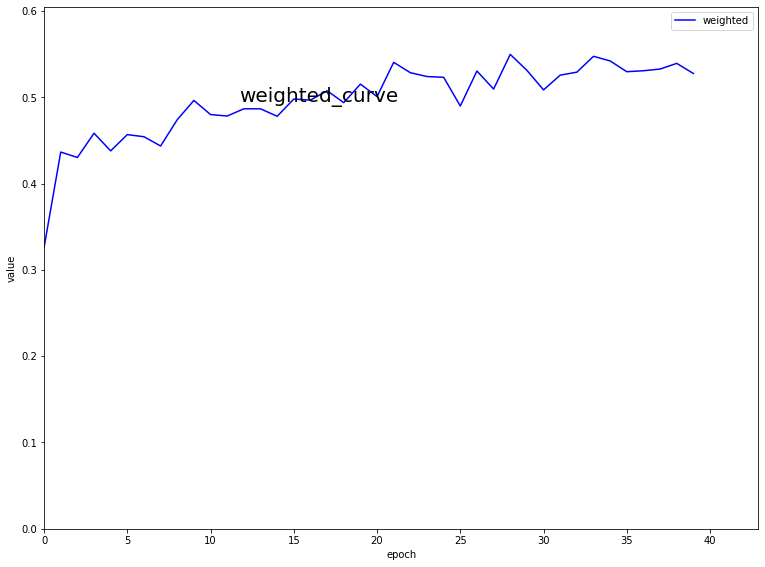

In [73]:
paint('train_loss', 'b', 40)
paint('train_ratio', 'g', 40)
paint('test_loss', 'c', 40)
paint('test_ratio', 'r', 40)
paint('corr', 'r', 40)
paint('macro', 'b', 40)
paint('micro', 'b', 40)
paint('weighted', 'b', 40)

In [33]:
print('argmax test ratio', np.argmax(test_ratio_list))
print('epoch 30', test_ratio_list[29])

argmax test ratio 29
epoch 30 0.6063734290843806


In [13]:
train_size = 2342
test_size = 2228
input_size, hidden_size, output_size = 300, 100, 8
model = TwoLayerNet(input_size, hidden_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

for epoch in range(500):
    model.train()
    ave_loss = 0.0
    traincnt = 0
    for feat, label in trainloader:
        optimizer.zero_grad()
        pred = model(feat)
        loss = loss_fn(pred, label)
        loss.backward()
        ave_loss += loss.item()
        optimizer.step()
        traincnt += 1
    print('Epoch %d,\t loss %f' % (epoch, ave_loss / traincnt), end='\t')
    
    model.eval()
    evalcnt = 0
    for feat, label in testset:
        if torch.argmax(model(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
            evalcnt += 1
    print('ratio:', evalcnt / test_size)
torch.save(model.state_dict(), 'new_mlp_para.dict')

In [ ]:
net2 = TwoLayerNet(input_size, hidden_size, output_size)
net2.load_state_dict(torch.load('new_mlp_para.dict'))
net2.eval()

cnt = 0
# for feat, label in testset:
pred_emotions = list()
true_emotions = list()
for feat, label in testset:
    # print(label)
    if torch.argmax(net2(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
        cnt += 1
    pred_emotions.append(int(torch.argmax(net2(torch.Tensor(feat))).item()))
    true_emotions.append(int(torch.argmax(torch.Tensor(label)).item()))
    
print('correct:', cnt)
print('ratio:', cnt / test_size)


# 返回值的第一项是皮尔森相关系数，第二项是p_value值。一般来说皮尔森相关系数越大，p_value越小，线性相关性就越大。但是看到note里讲的。p_value不是完全的可靠，当数据量大于500的时候，可能是合理的。
pears = list()
for feat, label in testset:
    pred = torch.Tensor(net2(feat)[0]).detach().numpy()
    # print(pred, label)
    pears.append(pearsonr(label, pred))

# print(pears)
corr = 0
for pair in pears:
    corr += pair[0]
corr /= len(pears)
print(corr)

print(f1_score(true_emotions, pred_emotions, average='macro'))
print(f1_score(true_emotions, pred_emotions, average='weighted'))
# corr -> 0.6611378491929296
# ma -> 0.3289856648150263
# mi -> 0.5501562344438627

In [14]:
# Epoch 0,	 loss 0.044360	ratio: 0.46409335727109513
# Epoch 1,	 loss 0.036265	ratio: 0.5385996409335727
# Epoch 2,	 loss 0.034133	ratio: 0.5471274685816876
# Epoch 3,	 loss 0.032935	ratio: 0.5610412926391383
# Epoch 4,	 loss 0.032075	ratio: 0.5574506283662477
# Epoch 5,	 loss 0.031474	ratio: 0.566427289048474
# Epoch 6,	 loss 0.030763	ratio: 0.5691202872531418
# Epoch 7,	 loss 0.030335	ratio: 0.5749551166965888
# Epoch 8,	 loss 0.029956	ratio: 0.5758527827648114
# Epoch 9,	 loss 0.029613	ratio: 0.5763016157989228
# Epoch 10,	 loss 0.029141	ratio: 0.5803411131059246
# Epoch 11,	 loss 0.028810	ratio: 0.5821364452423698
# Epoch 12,	 loss 0.028460	ratio: 0.5848294434470377
# Epoch 13,	 loss 0.028144	ratio: 0.5879712746858169
# Epoch 14,	 loss 0.028133	ratio: 0.585278276481149
# Epoch 15,	 loss 0.027683	ratio: 0.5866247755834829
# Epoch 16,	 loss 0.027620	ratio: 0.5812387791741472
# Epoch 17,	 loss 0.027368	ratio: 0.5897666068222621
# Epoch 18,	 loss 0.027069	ratio: 0.5843806104129264
# Epoch 19,	 loss 0.026877	ratio: 0.5920107719928187
# Epoch 20,	 loss 0.026766	ratio: 0.5964991023339318
# Epoch 21,	 loss 0.026455	ratio: 0.5861759425493717
# Epoch 22,	 loss 0.026329	ratio: 0.5933572710951526
# Epoch 23,	 loss 0.026253	ratio: 0.5960502692998204
# Epoch 24,	 loss 0.026766	ratio: 0.5861759425493717
# Epoch 25,	 loss 0.025983	ratio: 0.59245960502693
# Epoch 26,	 loss 0.025718	ratio: 0.5956014362657092
# Epoch 27,	 loss 0.025768	ratio: 0.6018850987432675
# Epoch 28,	 loss 0.025556	ratio: 0.5951526032315978
# Epoch 29,	 loss 0.025388	ratio: 0.5951526032315978
# Epoch 30,	 loss 0.025263	ratio: 0.5991921005385996
# Epoch 31,	 loss 0.025343	ratio: 0.5969479353680431
# Epoch 32,	 loss 0.024891	ratio: 0.5929084380610413
# Epoch 33,	 loss 0.024965	ratio: 0.5960502692998204
# Epoch 34,	 loss 0.024825	ratio: 0.599640933572711
# Epoch 35,	 loss 0.024711	ratio: 0.6036804308797128
# Epoch 36,	 loss 0.024679	ratio: 0.5973967684021544
# Epoch 37,	 loss 0.024671	ratio: 0.5947037701974865
# Epoch 38,	 loss 0.024590	ratio: 0.604129263913824
# Epoch 39,	 loss 0.024297	ratio: 0.6023339317773788
# Epoch 40,	 loss 0.024175	ratio: 0.6045780969479354
# Epoch 41,	 loss 0.023943	ratio: 0.6032315978456014
# Epoch 42,	 loss 0.023961	ratio: 0.5973967684021544
# Epoch 43,	 loss 0.023870	ratio: 0.5920107719928187
# Epoch 44,	 loss 0.023921	ratio: 0.5991921005385996
# Epoch 45,	 loss 0.023804	ratio: 0.5942549371633752
# Epoch 46,	 loss 0.023491	ratio: 0.6005385996409336
# Epoch 47,	 loss 0.023675	ratio: 0.5987432675044884
# Epoch 48,	 loss 0.023622	ratio: 0.6000897666068222
# Epoch 49,	 loss 0.023404	ratio: 0.599640933572711
# Epoch 50,	 loss 0.023177	ratio: 0.5978456014362658
# Epoch 51,	 loss 0.023343	ratio: 0.6063734290843806
# Epoch 52,	 loss 0.023444	ratio: 0.6005385996409336
# Epoch 53,	 loss 0.023151	ratio: 0.6009874326750448
# Epoch 54,	 loss 0.022760	ratio: 0.5951526032315978
# Epoch 55,	 loss 0.022900	ratio: 0.6000897666068222
# Epoch 56,	 loss 0.022745	ratio: 0.6018850987432675
# Epoch 57,	 loss 0.022843	ratio: 0.6068222621184919
# Epoch 58,	 loss 0.022551	ratio: 0.6077199281867145
# Epoch 59,	 loss 0.022618	ratio: 0.6036804308797128
# Epoch 60,	 loss 0.022501	ratio: 0.6009874326750448
# Epoch 61,	 loss 0.022388	ratio: 0.6050269299820467
# Epoch 62,	 loss 0.022395	ratio: 0.6032315978456014
# Epoch 63,	 loss 0.022239	ratio: 0.6014362657091562
# Epoch 64,	 loss 0.022342	ratio: 0.6068222621184919
# Epoch 65,	 loss 0.022015	ratio: 0.6063734290843806
# Epoch 66,	 loss 0.022015	ratio: 0.6005385996409336
# Epoch 67,	 loss 0.022017	ratio: 0.5987432675044884
# Epoch 68,	 loss 0.022377	ratio: 0.6032315978456014
# Epoch 69,	 loss 0.021849	ratio: 0.6045780969479354
# Epoch 70,	 loss 0.021738	ratio: 0.6072710951526032
# Epoch 71,	 loss 0.021845	ratio: 0.6095152603231598
# Epoch 72,	 loss 0.021664	ratio: 0.6036804308797128
# Epoch 73,	 loss 0.021468	ratio: 0.6045780969479354
# Epoch 74,	 loss 0.021502	ratio: 0.6027827648114902
# Epoch 75,	 loss 0.021256	ratio: 0.6018850987432675
# Epoch 76,	 loss 0.021228	ratio: 0.6059245960502693
# Epoch 77,	 loss 0.021404	ratio: 0.6068222621184919
# Epoch 78,	 loss 0.021202	ratio: 0.6027827648114902
# Epoch 79,	 loss 0.021095	ratio: 0.5973967684021544
# Epoch 80,	 loss 0.021374	ratio: 0.6032315978456014
# Epoch 81,	 loss 0.020974	ratio: 0.5964991023339318
# Epoch 82,	 loss 0.021045	ratio: 0.6018850987432675
# Epoch 83,	 loss 0.020803	ratio: 0.6063734290843806
# Epoch 84,	 loss 0.020894	ratio: 0.6014362657091562
# Epoch 85,	 loss 0.020889	ratio: 0.6095152603231598
# Epoch 86,	 loss 0.020699	ratio: 0.6068222621184919
# Epoch 87,	 loss 0.020670	ratio: 0.6050269299820467
# Epoch 88,	 loss 0.021004	ratio: 0.6036804308797128
# Epoch 89,	 loss 0.020945	ratio: 0.6032315978456014
# Epoch 90,	 loss 0.020657	ratio: 0.5991921005385996
# Epoch 91,	 loss 0.020475	ratio: 0.6032315978456014
# Epoch 92,	 loss 0.020495	ratio: 0.6014362657091562
# Epoch 93,	 loss 0.020494	ratio: 0.599640933572711
# Epoch 94,	 loss 0.020256	ratio: 0.6032315978456014
# Epoch 95,	 loss 0.020138	ratio: 0.6081687612208259
# Epoch 96,	 loss 0.020215	ratio: 0.5973967684021544
# Epoch 97,	 loss 0.020597	ratio: 0.6014362657091562
# Epoch 98,	 loss 0.020030	ratio: 0.6005385996409336
# Epoch 99,	 loss 0.019943	ratio: 0.6005385996409336